In [109]:
from pathlib import Path

MAX_DATA_PATH = Path("C:/Users/maxpd/Desktop/483 ML/Intrusion Detection/483-final-project-datasets/OPCUA_dataset_public.csv")
CHRIS_DATA_PATH = Path("/Users/chriszinati/Desktop/CPSC-483/final project datasets/483-final-project-datasets/OPCUA_dataset_public.csv")

**Data Cleaning**
- delete rows with missing data
- get rid of noisy data (in our case, all non-ddos anomalies)
- drop the multiclass target label (since were only looking at ddos vs normal (1 or 0))
- dropped source and destination ip and port (useless features)

In [110]:
import pandas as pd
#Stops showing values in scientific notation
pd.set_option('display.float_format', lambda x: f'{x:.4f}')


#it isn't reading just the relative path for some reason, so use the whole path
df = pd.read_csv(MAX_DATA_PATH)

instancesToDrop= ['MITM', 'Impersonation'] 
df = (df[df.multi_label.isin(instancesToDrop) == False]) #drop instances of MITM and Impersonation
df = df.drop('multi_label', axis=1) #drop multiclass label
df = df.drop('src_ip', axis=1) #drop source ip label
df = df.drop('src_port', axis=1) #drop source port label
df = df.drop('dst_ip', axis=1) #drop destination ip label
df = df.drop('dst_port', axis=1) #drop destination port label
print(df) #should be 107578 rows x 26 columns insetead of  107634 rows x 32 columns now



        flags  pktTotalCount  octetTotalCount   avg_ps  proto  \
0           1              2              219 109.5000  OPCUA   
1           1              2              219 109.5000  OPCUA   
2           1              2              399 199.5000  OPCUA   
3           1              2              399 199.5000  OPCUA   
4           1              2              219 109.5000  OPCUA   
...       ...            ...              ...      ...    ...   
107628      1              2              359 179.5000  OPCUA   
107629      1              2              358 179.0000  OPCUA   
107630      1              2              359 179.5000  OPCUA   
107631      1              2              359 179.5000  OPCUA   
107632      1              2              359 179.5000  OPCUA   

                   service  service_errors  status_errors  msg_size  \
0       StartRawConnection               0              0        87   
1       StartRawConnection               0              0        87   
2     

In [111]:
#balancing the data, 50/50 anomaly and normal
label_0 = df[df['label'] == 0]
label_1 = df[df['label'] == 1]
label_0_samples = label_0.sample(n = 33000, random_state= 42)
label_1_samples = label_1.sample(n = 33000, random_state = 42)

balanced_df = pd.concat([label_0_samples, label_1_samples])
df_balanced = balanced_df.sample(frac = 1, random_state= 42).reset_index(drop=True)

df = df_balanced
print(df)

       flags  pktTotalCount  octetTotalCount   avg_ps  proto  \
0          1              2              359 179.5000  OPCUA   
1          0              1               86  86.0000  OPCUA   
2          0              1               86  86.0000  OPCUA   
3          1              2              359 179.5000  OPCUA   
4          0              1               86  86.0000  OPCUA   
...      ...            ...              ...      ...    ...   
65995      0              1               86  86.0000  OPCUA   
65996      1              2              358 179.0000  OPCUA   
65997      0              1               86  86.0000  OPCUA   
65998      1              2              359 179.5000  OPCUA   
65999      1              2              358 179.0000  OPCUA   

                  service  service_errors  status_errors  msg_size  \
0               Attribute               0              0       227   
1      StartRawConnection               0              0        32   
2      StartRawConnec

In [112]:
duplicates = df.duplicated()
print('Duplicated rows: ', duplicates.sum())
print(df[duplicates])

Duplicated rows:  0
Empty DataFrame
Columns: [flags, pktTotalCount, octetTotalCount, avg_ps, proto, service, service_errors, status_errors, msg_size, min_msg_size, flowStart, flowEnd, flowDuration, avg_flowDuration, flowInterval, count, srv_count, same_srv_rate, dst_host_same_src_port_rate, f_pktTotalCount, f_octetTotalCount, f_flowStart, f_rate, b_pktTotalCount, b_octetTotalCount, b_flowStart, label]
Index: []

[0 rows x 27 columns]


In [113]:
df.isnull().sum()

flags                          0
pktTotalCount                  0
octetTotalCount                0
avg_ps                         0
proto                          0
service                        0
service_errors                 0
status_errors                  0
msg_size                       0
min_msg_size                   0
flowStart                      0
flowEnd                        0
flowDuration                   0
avg_flowDuration               0
flowInterval                   0
count                          0
srv_count                      0
same_srv_rate                  0
dst_host_same_src_port_rate    0
f_pktTotalCount                0
f_octetTotalCount              0
f_flowStart                    0
f_rate                         0
b_pktTotalCount                0
b_octetTotalCount              0
b_flowStart                    0
label                          0
dtype: int64

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66000 entries, 0 to 65999
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flags                        66000 non-null  int64  
 1   pktTotalCount                66000 non-null  int64  
 2   octetTotalCount              66000 non-null  int64  
 3   avg_ps                       66000 non-null  float64
 4   proto                        66000 non-null  object 
 5   service                      66000 non-null  object 
 6   service_errors               66000 non-null  int64  
 7   status_errors                66000 non-null  int64  
 8   msg_size                     66000 non-null  int64  
 9   min_msg_size                 66000 non-null  int64  
 10  flowStart                    66000 non-null  float64
 11  flowEnd                      66000 non-null  float64
 12  flowDuration                 66000 non-null  float64
 13  avg_flowDuration

In [115]:
min_max_df = df.describe().loc[['min', 'max']].transpose().round(4)
print(min_max_df)

                                                 min                       max
flags                                         0.0000                    1.0000
pktTotalCount                                 1.0000                   17.0000
octetTotalCount                              86.0000                 3314.0000
avg_ps                                       86.0000                  490.5000
service_errors                                0.0000                    0.0000
status_errors                                 0.0000                    0.0000
msg_size                                     32.0000                 2192.0000
min_msg_size                                 28.0000                  272.0000
flowStart                            1583854854.0882           1583862251.6785
flowEnd                              1583854854.0937           1583862251.6862
flowDuration                                  0.0000                  717.8090
avg_flowDuration                              0.0000

In [116]:
encode_required = ['proto', 'service']

In [117]:
stats = df[['service_errors', 'status_errors', 'proto', 'service']].describe()
rows = df[['service_errors', 'status_errors', 'proto', 'service']].head(10)
print(stats)
print(rows)

       service_errors  status_errors
count      66000.0000     66000.0000
mean           0.0000         0.0000
std            0.0000         0.0000
min            0.0000         0.0000
25%            0.0000         0.0000
50%            0.0000         0.0000
75%            0.0000         0.0000
max            0.0000         0.0000
   service_errors  status_errors  proto             service
0               0              0  OPCUA           Attribute
1               0              0  OPCUA  StartRawConnection
2               0              0  OPCUA  StartRawConnection
3               0              0  OPCUA           Attribute
4               0              0  OPCUA  StartRawConnection
5               0              0  OPCUA           Attribute
6               0              0  OPCUA           Attribute
7               0              0  OPCUA           Attribute
8               0              0  OPCUA           Attribute
9               0              0  OPCUA  StartRawConnection


In [118]:
#Checking all unique values of features that are objects
print('Service values: ', df['service'].unique())
print('Proto values: ', df['proto'].unique())

Service values:  ['Attribute' 'StartRawConnection' 'SecureChannel' 'Session']
Proto values:  ['OPCUA']


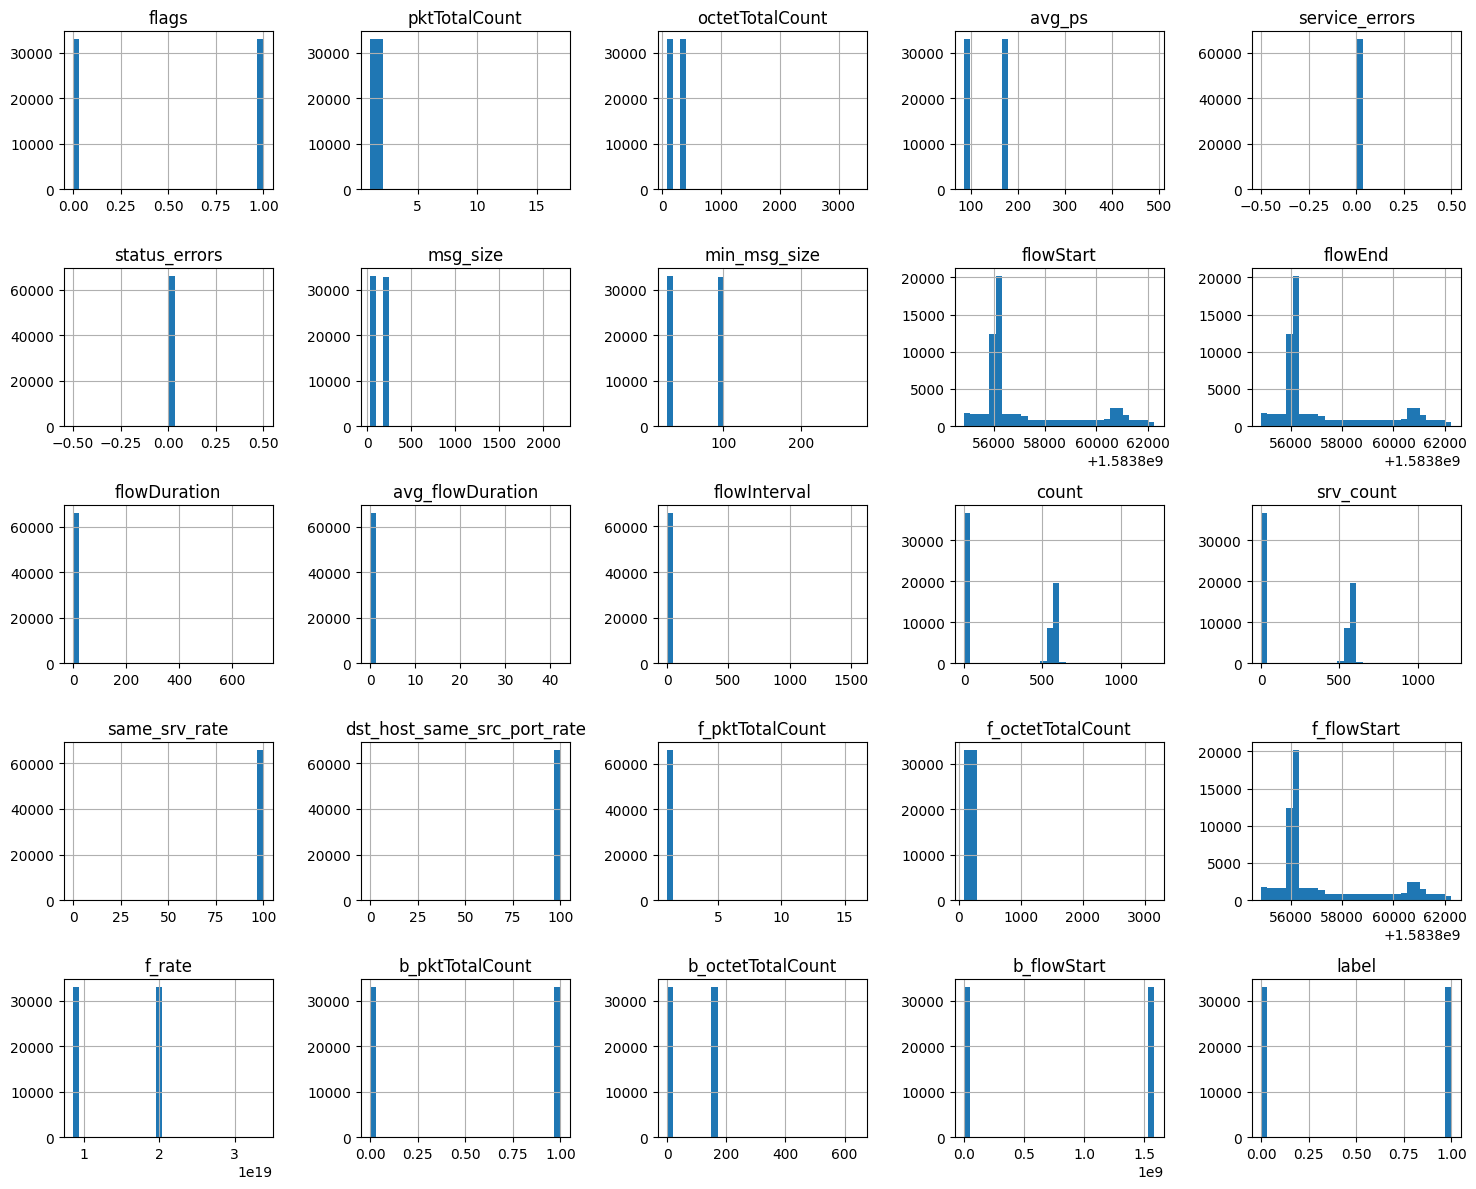

In [119]:
#checking distribution
import matplotlib.pyplot as plt

df.hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

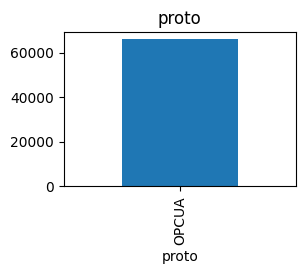

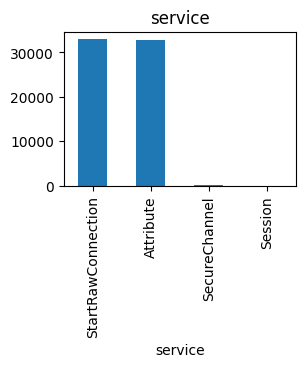

In [120]:
#Checking distribution of categorical features
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    plt.figure(figsize = (3,2))
    df[col].value_counts().plot(kind='bar', title=col)
    plt.show()


In [121]:
#checking variance
df.var(numeric_only=True).sort_values()

status_errors                                                      0.0000
service_errors                                                     0.0000
f_pktTotalCount                                                    0.0034
avg_flowDuration                                                   0.0270
b_pktTotalCount                                                    0.2500
label                                                              0.2500
flags                                                              0.2500
pktTotalCount                                                      0.2536
flowDuration                                                       7.8067
same_srv_rate                                                     12.7376
dst_host_same_src_port_rate                                       12.9036
flowInterval                                                      39.3387
min_msg_size                                                    1023.7976
avg_ps                                

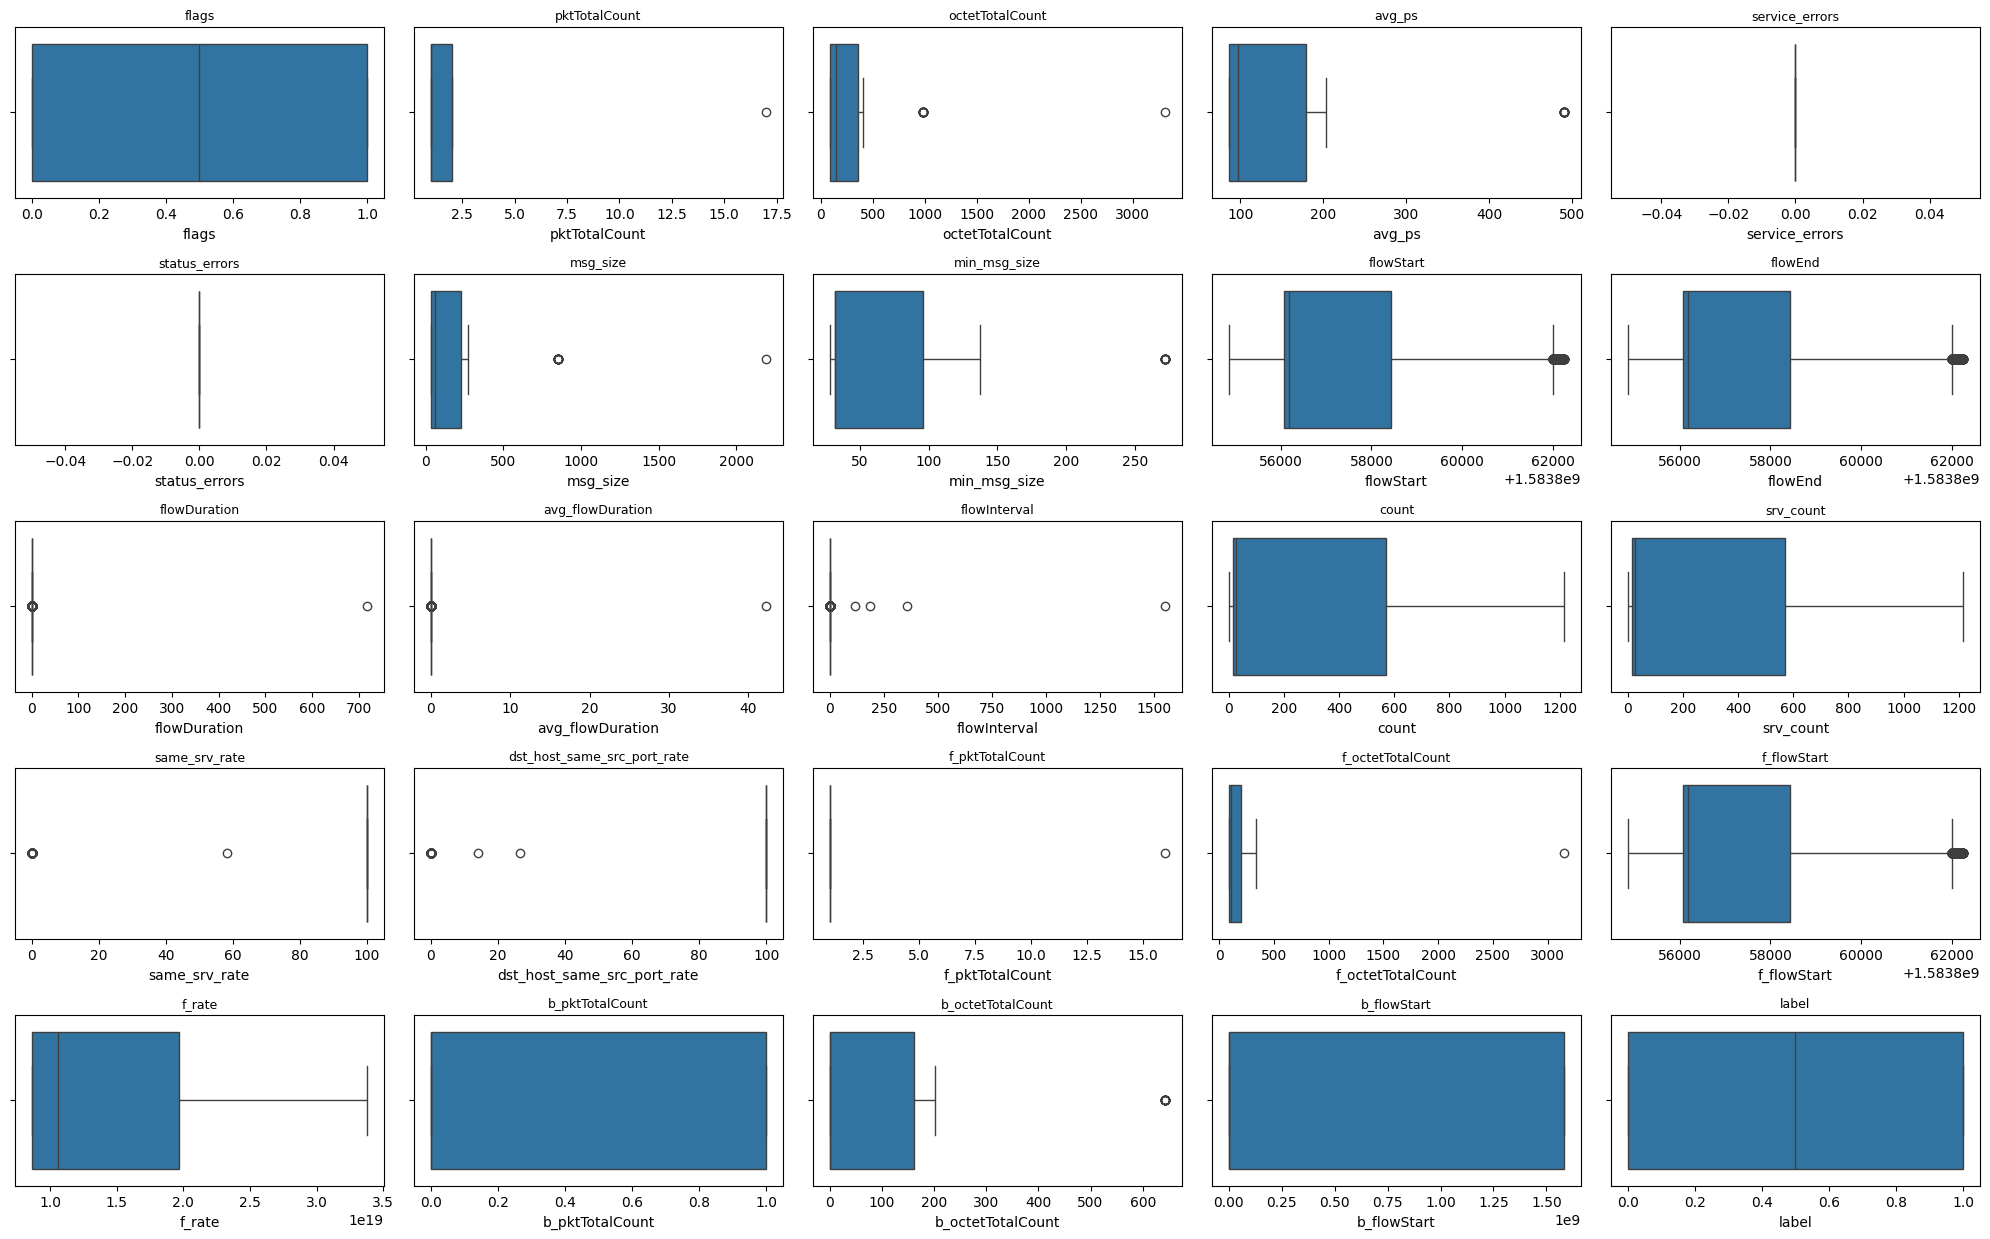

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include='number').columns
n_cols = 5
n_rows = -(-len(numeric_cols) // n_cols)

plt.figure(figsize=(n_cols * 4, n_rows * 2.5))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col])
    plt.title(col, fontsize=9)
    plt.tight_layout()

plt.show()

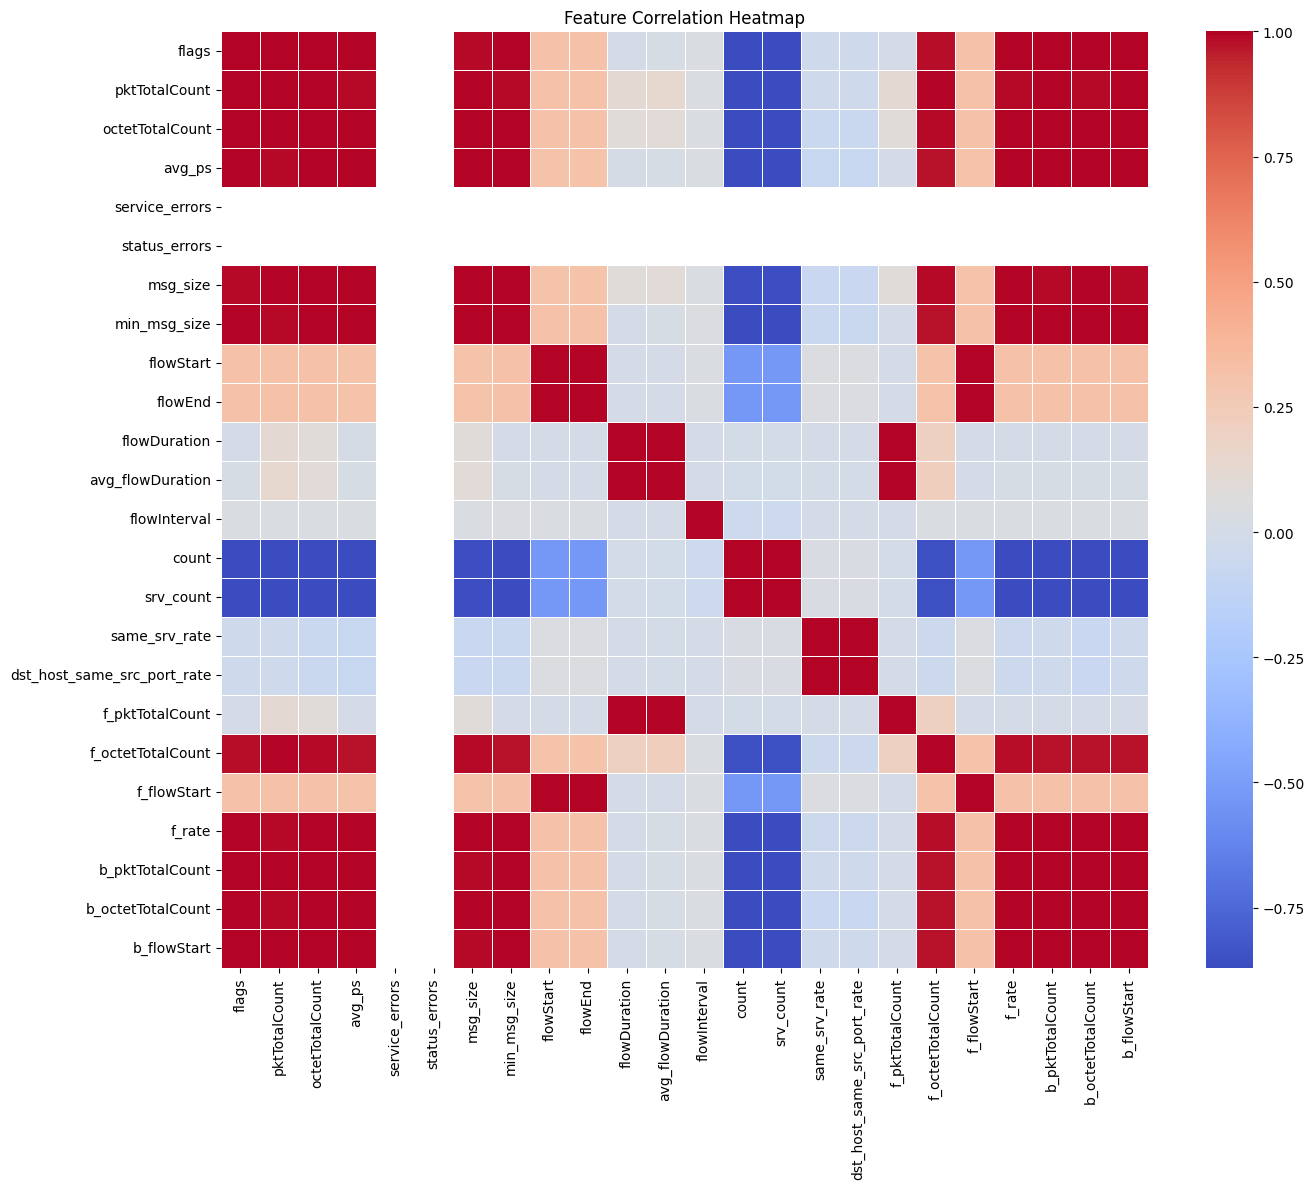

                              flags  pktTotalCount  octetTotalCount  avg_ps  \
flags                        1.0000         0.9929           0.9937  0.9942   
pktTotalCount                0.9929         1.0000           0.9967  0.9871   
octetTotalCount              0.9937         0.9967           1.0000  0.9958   
avg_ps                       0.9942         0.9871           0.9958  1.0000   
service_errors                  NaN            NaN              NaN     NaN   
status_errors                   NaN            NaN              NaN     NaN   
msg_size                     0.9916         0.9939           0.9996  0.9969   
min_msg_size                 0.9950         0.9874           0.9954  0.9995   
flowStart                    0.3172         0.3151           0.3137  0.3130   
flowEnd                      0.3172         0.3153           0.3139  0.3130   
flowDuration                 0.0054         0.1213           0.0892  0.0067   
avg_flowDuration             0.0170         0.1328  

In [123]:
corr_matrix = df.drop(columns=['label']).select_dtypes(include='number').corr().round(4)

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
print(corr_matrix)

In [124]:
import numpy as np
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
dropped_features = [col for col in upper.columns if any(upper[col] > 0.95)]
df = df.drop(columns = dropped_features)
print("Dropped features due to high correlation:", dropped_features)

Dropped features due to high correlation: ['pktTotalCount', 'octetTotalCount', 'avg_ps', 'msg_size', 'min_msg_size', 'flowEnd', 'avg_flowDuration', 'srv_count', 'dst_host_same_src_port_rate', 'f_pktTotalCount', 'f_octetTotalCount', 'f_flowStart', 'f_rate', 'b_pktTotalCount', 'b_octetTotalCount', 'b_flowStart']


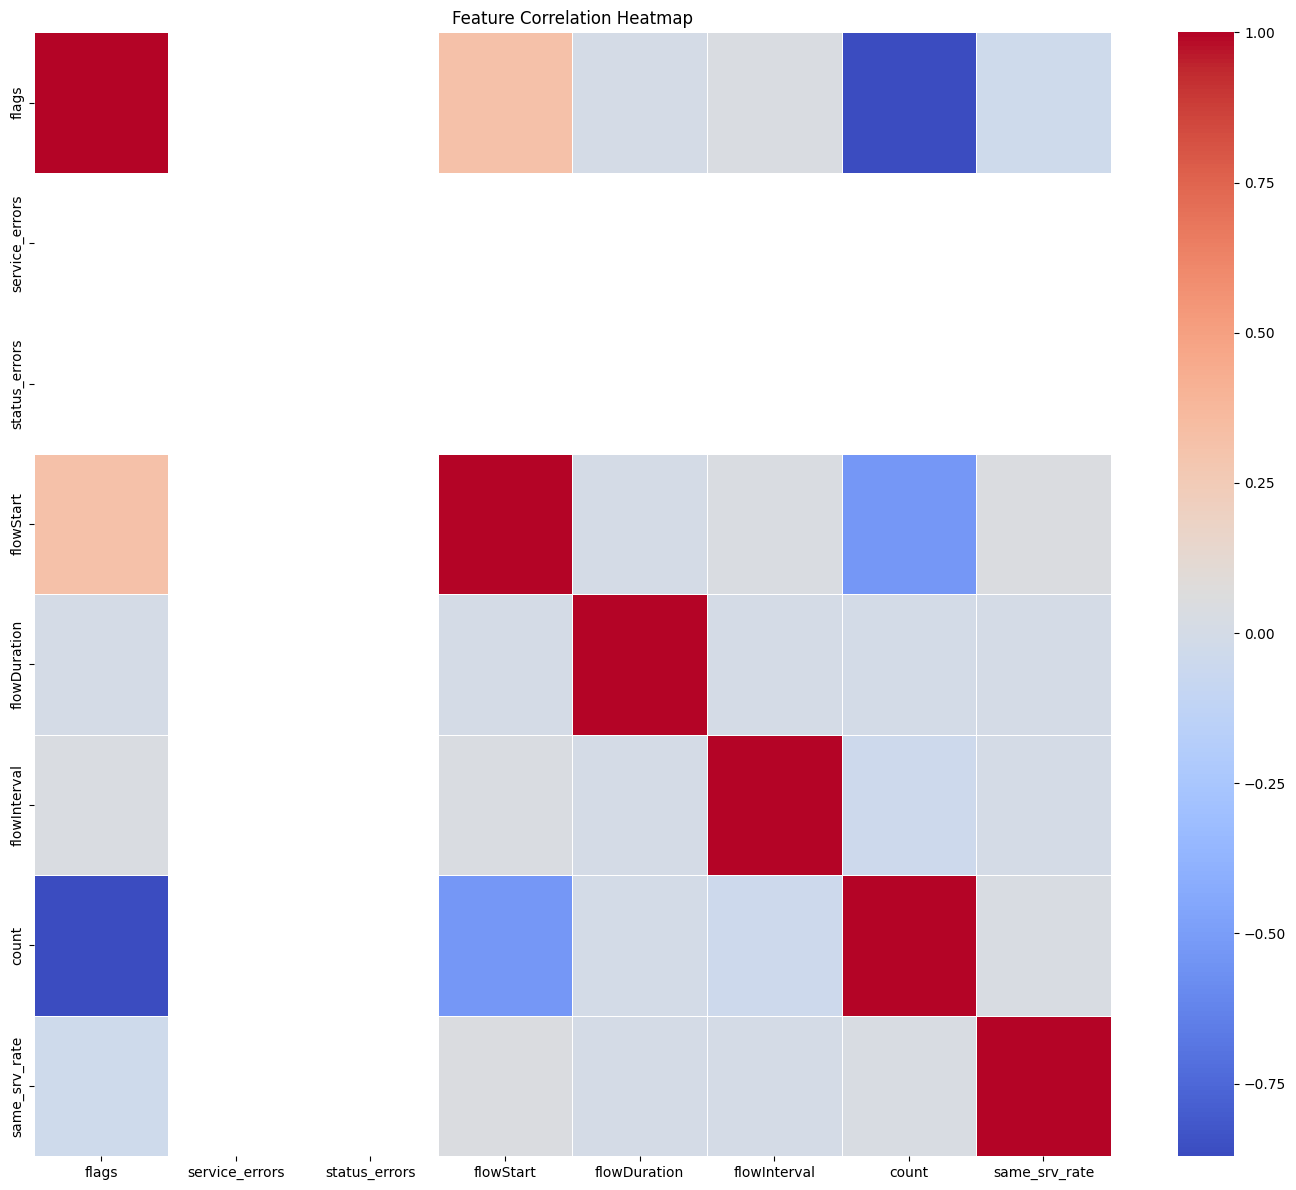

In [125]:
corr_matrix_updated = df.drop(columns=['label']).select_dtypes(include='number').corr().round(4)
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_updated, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

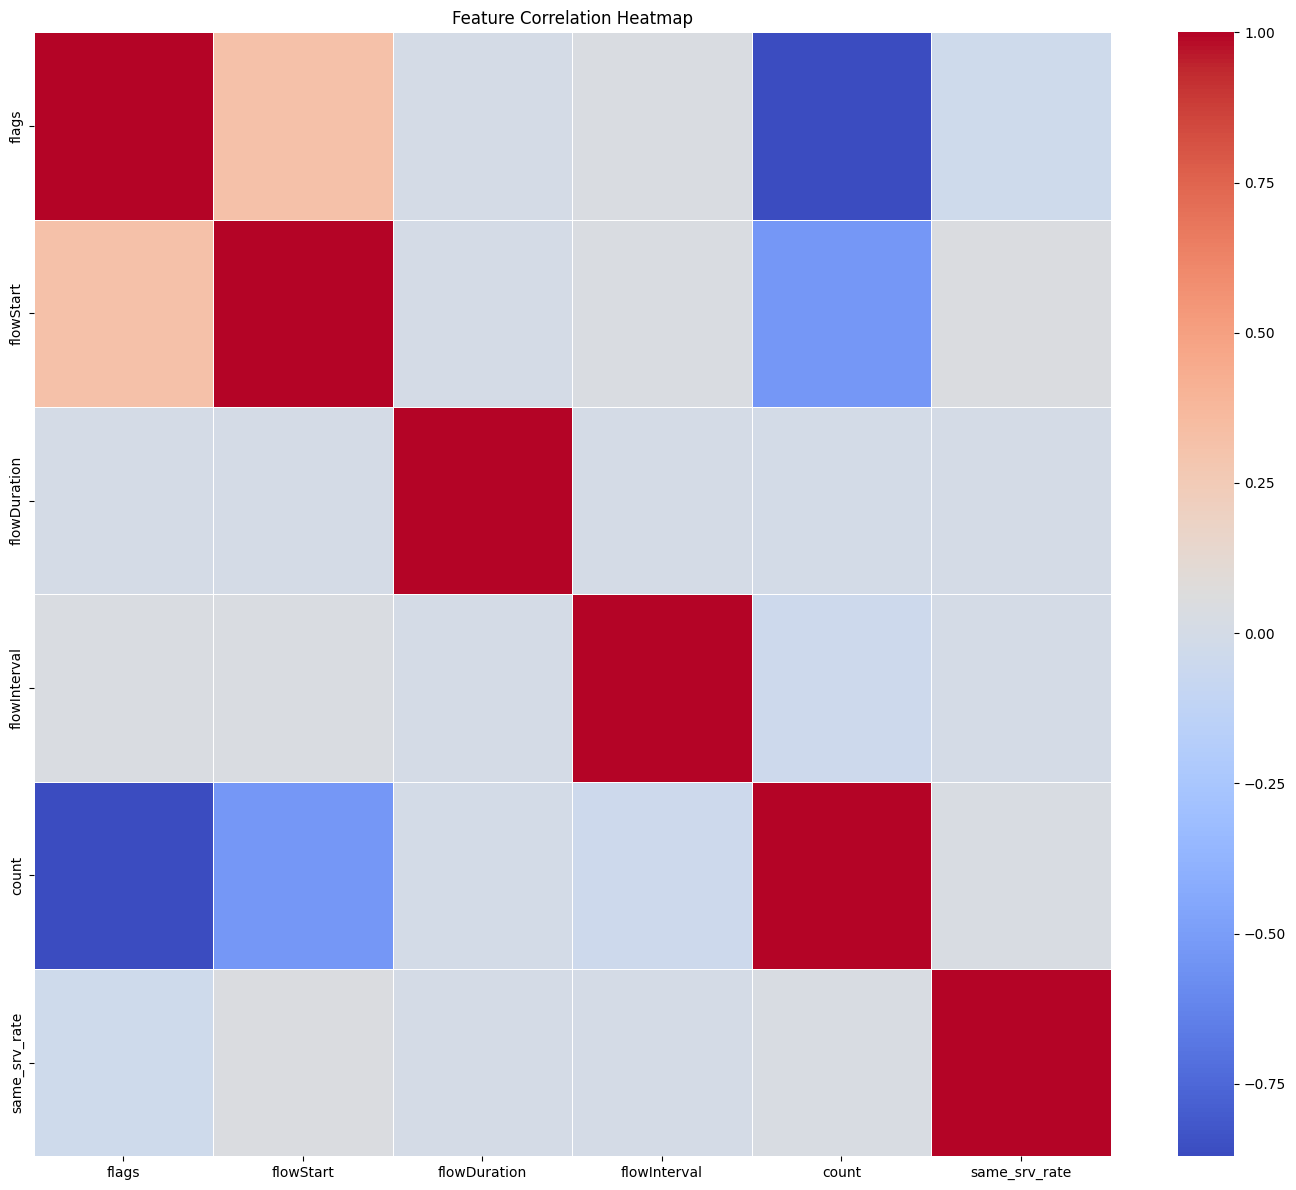

In [126]:
df = df.drop(['status_errors', 'service_errors'], axis = 1)
corr_matrix_updated2 = df.drop(columns=['label']).select_dtypes(include='number').corr().round(4)
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_updated2, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [127]:
#Splitting data BEFORE further processing
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 29)

In [128]:
#Building a pipeline for transformations and modeling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numerical_columns = [item for item in X_train.columns if item not in categorical_cols]

preprocessor = ColumnTransformer(transformers = [('object', OneHotEncoder(handle_unknown= 'ignore', sparse_output = False), categorical_cols),
                                                 ('numbers', StandardScaler(), numerical_columns)])


In [130]:
X_train_encoded = preprocessor.fit_transform(X_train)
encoded_feature_names = preprocessor.get_feature_names_out()
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_train_encoded_df['label'] = y_train

In [131]:
X_test_encoded = preprocessor.transform(X_test)
encoded_feature_names = preprocessor.get_feature_names_out()
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)
X_test_encoded_df['label'] = y_test

In [132]:
correlations_with_label = X_train_encoded_df.corr(numeric_only=True)['label'].drop('label')
print(correlations_with_label)

object__proto_OPCUA                      NaN
object__service_Attribute            -0.9967
object__service_SecureChannel        -0.0285
object__service_Session              -0.0242
object__service_StartRawConnection    0.9995
numbers__flags                       -1.0000
numbers__flowStart                   -0.3159
numbers__flowDuration                -0.9356
numbers__flowInterval                -0.1164
numbers__count                        0.8704
numbers__same_srv_rate                0.0363
Name: label, dtype: float64


In [133]:
range = X_train_encoded_df.describe().loc[['min', 'max']].transpose().round(4)
print(range)

                                        min      max
object__proto_OPCUA                  1.0000   1.0000
object__service_Attribute            0.0000   1.0000
object__service_SecureChannel        0.0000   1.0000
object__service_Session              0.0000   1.0000
object__service_StartRawConnection   0.0000   1.0000
numbers__flags                      -1.0021   0.9979
numbers__flowStart                  -1.2421   2.5438
numbers__flowDuration               -0.9375  13.3516
numbers__flowInterval               -0.1414 190.7503
numbers__count                      -0.9474   3.4384
numbers__same_srv_rate             -27.6095   0.0363
label                                0.0000   1.0000


In [134]:
cut_off = 0.9
high_corr_features = correlations_with_label[correlations_with_label.abs() > cut_off].index.tolist()
print(high_corr_features)
X_train_encoded_df = X_train_encoded_df.drop(columns = high_corr_features)
X_test_encoded_df = X_test_encoded_df.drop(columns = high_corr_features)

['object__service_Attribute', 'object__service_StartRawConnection', 'numbers__flags', 'numbers__flowDuration']


In [136]:
X_train_clean = X_train_encoded_df.drop(columns=['label'])
y_train = X_train_encoded_df['label']
X_test_clean = X_test_encoded_df.drop(columns=['label'])
y_test = X_test_encoded_df['label']

Training Models: 100%|█████████████████████████████████████████████████████████████████| 99/99 [03:13<00:00,  1.95s/it]


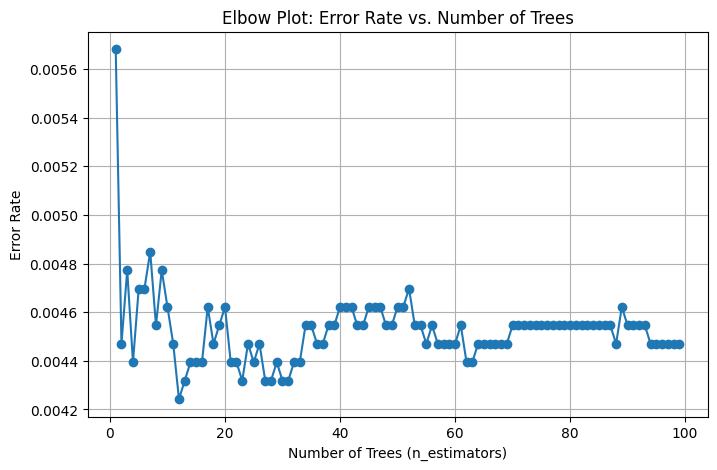

[0.9943181818181818, 0.995530303030303, 0.9952272727272727, 0.9956060606060606, 0.9953030303030304, 0.9953030303030304, 0.9951515151515151, 0.9954545454545455, 0.9952272727272727, 0.9953787878787879, 0.995530303030303, 0.9957575757575757, 0.9956818181818182, 0.9956060606060606, 0.9956060606060606, 0.9956060606060606, 0.9953787878787879, 0.995530303030303, 0.9954545454545455, 0.9953787878787879, 0.9956060606060606, 0.9956060606060606, 0.9956818181818182, 0.995530303030303, 0.9956060606060606, 0.995530303030303, 0.9956818181818182, 0.9956818181818182, 0.9956060606060606, 0.9956818181818182, 0.9956818181818182, 0.9956060606060606, 0.9956060606060606, 0.9954545454545455, 0.9954545454545455, 0.995530303030303, 0.995530303030303, 0.9954545454545455, 0.9954545454545455, 0.9953787878787879, 0.9953787878787879, 0.9953787878787879, 0.9954545454545455, 0.9954545454545455, 0.9953787878787879, 0.9953787878787879, 0.9953787878787879, 0.9954545454545455, 0.9954545454545455, 0.9953787878787879, 0.9953

In [139]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def elbow_plot(X_train_clean, y_train, X_test_clean, y_test):
    n_value = range(1, 100)
    error_rate = []
    accuracy_values = []

    for n in tqdm(n_value, desc="Training Models"):
        updated_model1 = RandomForestClassifier(
            n_estimators=n,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
        updated_model1.fit(X_train_clean, y_train)
        predictions = updated_model1.predict(X_test_clean)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_values.append(accuracy)

    error_rate = [1.0 - acc for acc in accuracy_values]

    plt.figure(figsize=(8, 5))
    plt.plot(n_value, error_rate, marker='o', linestyle='-')
    plt.xlabel('Number of Trees (n_estimators)')
    plt.ylabel('Error Rate')
    plt.title('Elbow Plot: Error Rate vs. Number of Trees')
    plt.grid(True)
    plt.show()

    return accuracy_values

accuracy_plot = elbow_plot(X_train_clean, y_train, X_test_clean, y_test)
print(accuracy_plot)


Training Models: 100%|█████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.26it/s]


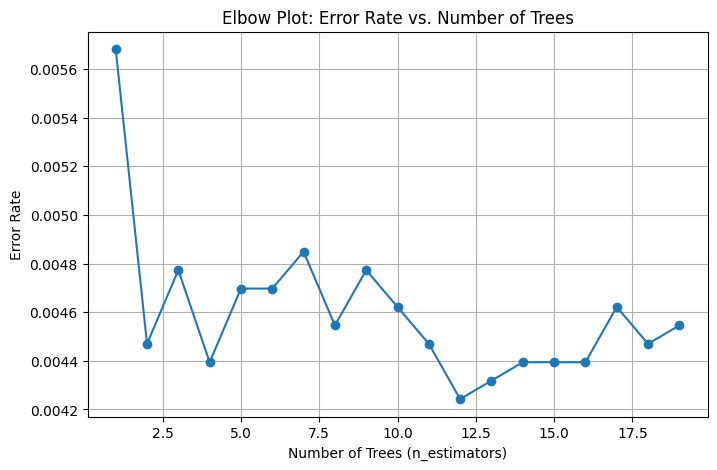

[0.9943181818181818, 0.995530303030303, 0.9952272727272727, 0.9956060606060606, 0.9953030303030304, 0.9953030303030304, 0.9951515151515151, 0.9954545454545455, 0.9952272727272727, 0.9953787878787879, 0.995530303030303, 0.9957575757575757, 0.9956818181818182, 0.9956060606060606, 0.9956060606060606, 0.9956060606060606, 0.9953787878787879, 0.995530303030303, 0.9954545454545455]


In [145]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def elbow_plot(X_train_clean, y_train, X_test_clean, y_test):
    n_value = range(1, 20)
    error_rate = []
    accuracy_values = []

    for n in tqdm(n_value, desc="Training Models"):
        updated_model1 = RandomForestClassifier(
            n_estimators=n,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
        updated_model1.fit(X_train_clean, y_train)
        predictions = updated_model1.predict(X_test_clean)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_values.append(accuracy)

    error_rate = [1.0 - acc for acc in accuracy_values]

    plt.figure(figsize=(8, 5))
    plt.plot(n_value, error_rate, marker='o', linestyle='-')
    plt.xlabel('Number of Trees (n_estimators)')
    plt.ylabel('Error Rate')
    plt.title('Elbow Plot: Error Rate vs. Number of Trees')
    plt.grid(True)
    plt.show()

    return accuracy_values

accuracy_plot = elbow_plot(X_train_clean, y_train, X_test_clean, y_test)
print(accuracy_plot)


Training Models: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


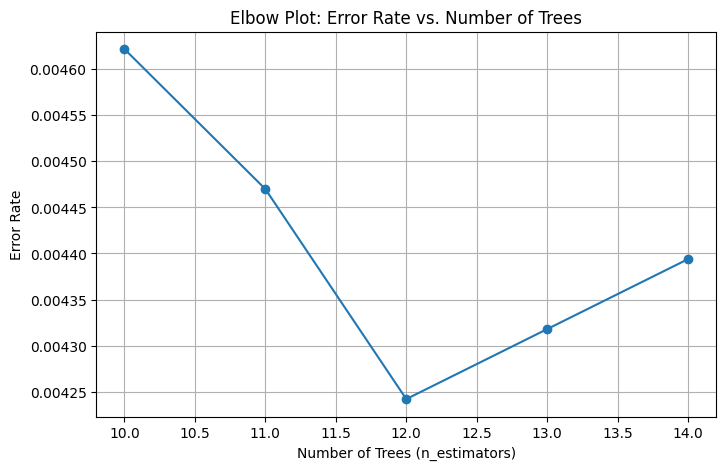

[0.9953787878787879, 0.995530303030303, 0.9957575757575757, 0.9956818181818182, 0.9956060606060606]


In [147]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def elbow_plot(X_train_clean, y_train, X_test_clean, y_test):
    n_value = range(10, 15)
    error_rate = []
    accuracy_values = []

    for n in tqdm(n_value, desc="Training Models"):
        updated_model1 = RandomForestClassifier(
            n_estimators=n,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
        updated_model1.fit(X_train_clean, y_train)
        predictions = updated_model1.predict(X_test_clean)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_values.append(accuracy)

    error_rate = [1.0 - acc for acc in accuracy_values]

    plt.figure(figsize=(8, 5))
    plt.plot(n_value, error_rate, marker='o', linestyle='-')
    plt.xlabel('Number of Trees (n_estimators)')
    plt.ylabel('Error Rate')
    plt.title('Elbow Plot: Error Rate vs. Number of Trees')
    plt.grid(True)
    plt.show()

    return accuracy_values

accuracy_plot = elbow_plot(X_train_clean, y_train, X_test_clean, y_test)
print(accuracy_plot)


Training Models: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.96it/s]


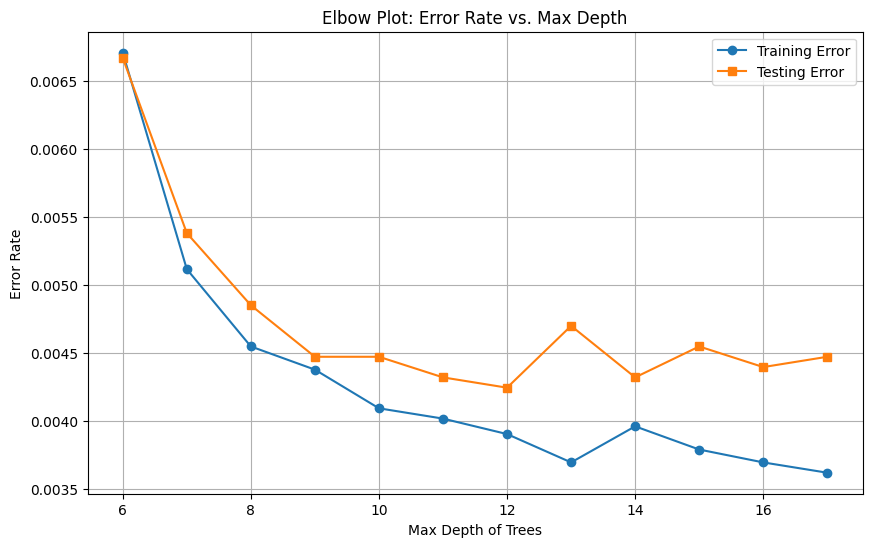

In [160]:
def elbow_plot(X_train_clean, y_train, X_test_clean, y_test):
    n_value = range(6, 18)
    error_rate_train = []
    error_rate_test = []
    accuracy_values_train = []
    accuracy_values_test = []

    for n in tqdm(n_value, desc="Training Models"):
        updated_model1 = RandomForestClassifier(
            n_estimators=12,
            max_depth=n,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
        updated_model1.fit(X_train_clean, y_train)
        prediction_train = updated_model1.predict(X_train_clean)
        prediction_test = updated_model1.predict(X_test_clean)
        accuracy_train = accuracy_score(y_clean, prediction_train)
        accuracy_test = accuracy_score(y_test, prediction_test)
        accuracy_values_train.append(accuracy_train)
        accuracy_values_test.append(accuracy_test)

    error_rate_train = [1.0 - acc for acc in accuracy_values_train]
    error_rate_test = [1.0 - acc for acc in accuracy_values_test]

    plt.figure(figsize=(10, 6))
    plt.plot(n_value, error_rate_train, label='Training Error', marker='o')
    plt.plot(n_value, error_rate_test, label='Testing Error', marker='s')
    plt.xlabel('Max Depth of Trees')
    plt.ylabel('Error Rate')
    plt.title('Elbow Plot: Error Rate vs. Max Depth')
    plt.legend()
    plt.grid(True)
    plt.show()

accuracy_plot = elbow_plot(X_train_clean, y_train, X_test_clean, y_test)

In [163]:
updated_model1 = RandomForestClassifier(n_estimators=12,
                                        max_depth=12,
                                        min_samples_split=10,
                                        min_samples_leaf=5,
                                        random_state=42
                                       )
updated_model1.fit(X_train_clean, y_train)
prediction_train = updated_model1.predict(X_train_clean)
prediction_test = updated_model1.predict(X_test_clean)
accuracy_train = accuracy_score(y_clean, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

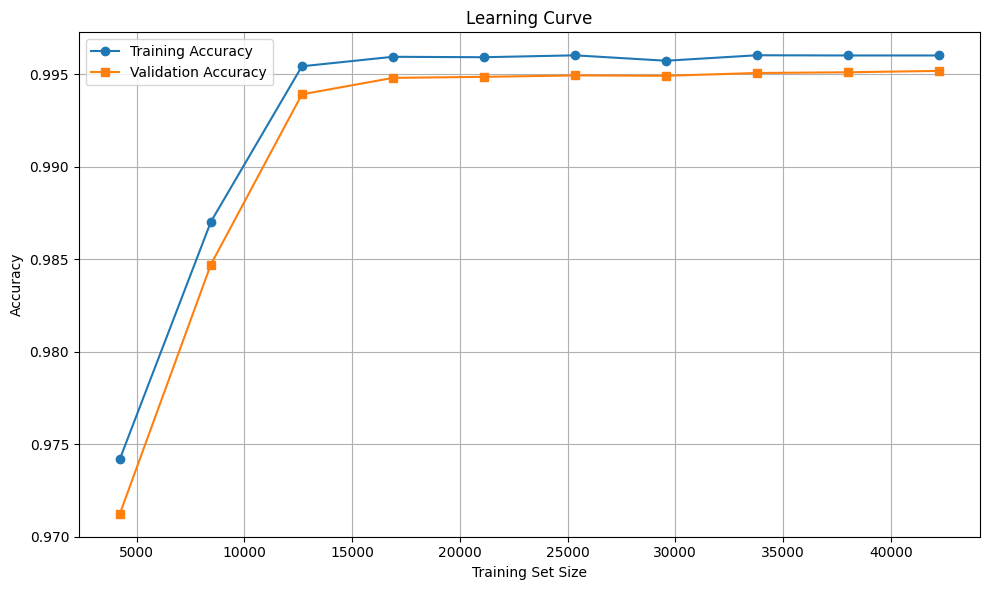

In [166]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=updated_model1, X=X_train_clean,
    y = y_train,
    cv = 5,
    train_sizes = np.linspace(0.1, 1.0, 10),
    scoring = 'accuracy',
    shuffle = True,
    random_state = 29
)
train_mean = train_scores.mean(axis = 1)
test_mean = test_scores.mean(axis = 1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='s')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [170]:
#NEW MODEL NAME IS RandomForestModel1_proccessed
#This is for the model that is now correct, optimized, and not overfitted
#This model was made with preprocessed data

In [168]:
import pickle
RandomForestModel1_proccessed = RandomForestClassifier(
    n_estimators=12,
    max_depth=10, 
    min_samples_split=10, 
    min_samples_leaf=5, 
    random_state=42)
RandomForestModel1_proccessed.fit(X_train_clean, y_train)
filename = 'RandomForestModel1_proccessed'
pickle.dump(RandomForestModel1_proccessed, open(filename, 'wb'))

In [171]:
#STUFF BELOW THIS NEEDS EDITING AND ORGANIZING 

In [215]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
updated_model1 = RandomForestClassifier(n_estimators=n, max_depth = 12, min_samples_split = 10, min_samples_leaf = 5, random_state=42)
cv = cross_validate(updated_model1, X_clean, y_clean, cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                    return_train_score = True)
print(pd.DataFrame(cv))

   fit_time  score_time  test_accuracy  train_accuracy  test_precision  \
0    3.2523      0.0803         0.9954          0.9961          0.9939   
1    2.9460      0.0629         0.9955          0.9960          0.9932   
2    2.8770      0.0788         0.9952          0.9961          0.9943   
3    3.2443      0.0790         0.9948          0.9962          0.9921   
4    3.0157      0.0630         0.9959          0.9961          0.9949   

   train_precision  test_recall  train_recall  test_f1  train_f1  
0           0.9941       0.9968        0.9981   0.9954    0.9961  
1           0.9940       0.9979        0.9980   0.9956    0.9960  
2           0.9942       0.9960        0.9981   0.9952    0.9961  
3           0.9944       0.9975        0.9980   0.9948    0.9962  
4           0.9947       0.9970        0.9975   0.9959    0.9961  


In [217]:
print(cv['test_accuracy'])

[0.99535985 0.99554924 0.99517045 0.99479167 0.99592803]


In [39]:
##Checking Correlation of all features to target label ONLY

In [70]:
#Finding correlation between all features, checking for redudancy 

In [75]:
#normalize features to common scale, using min-max scaling
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

X_train_normalized['label'] = y_train.values
X_test_normalized['label'] = y_test.values
print(X_train_normalized.describe().loc[['min','max']].transpose())





                   min      max
flowStart      -1.2421   2.5438
flowDuration   -0.9375  13.3516
flowInterval   -0.1414 190.7503
count          -0.9474   3.4384
same_srv_rate -27.6095   0.0363
label           0.0000   1.0000



Explained variance ratio for each principal component (all components):
  Component 1: 0.9859
  Component 2: 0.0141
  Component 3: 0.0000
  Component 4: 0.0000
  Component 5: 0.0000

Cumulative explained variance for all components:
  Up to Component 1: 0.9859
  Up to Component 2: 1.0000
  Up to Component 3: 1.0000
  Up to Component 4: 1.0000
  Up to Component 5: 1.0000

Minimum number of components to explain at least 95% variance: 1
Explained variance ratio for these selected components:
  Component 1: 0.9859


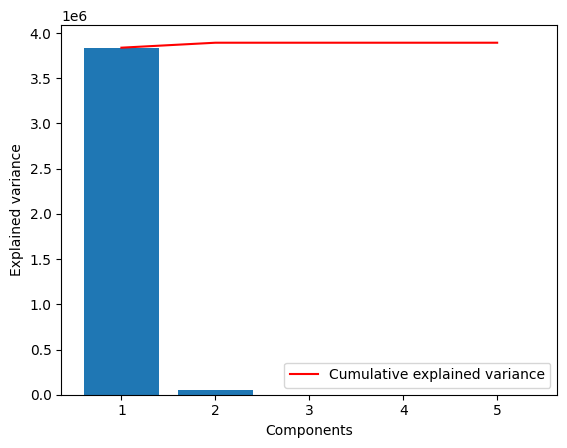

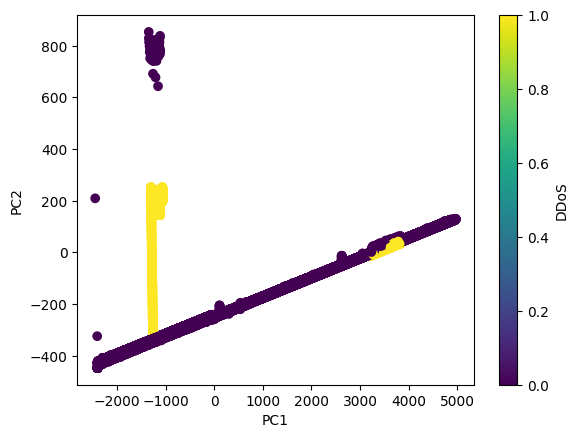

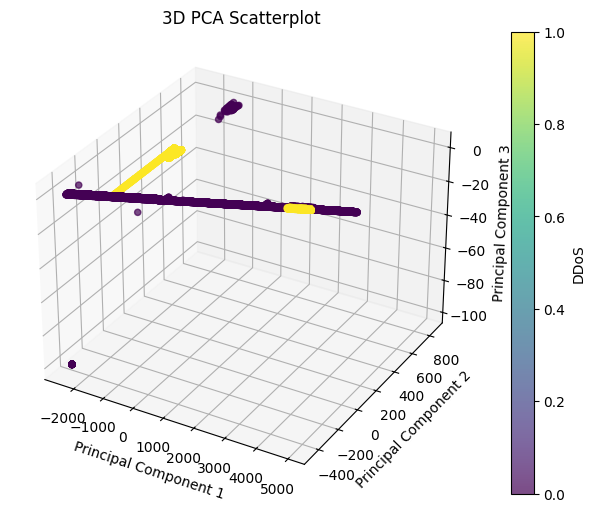

In [76]:
#apply PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

pca1 = PCA()
pca2 = PCA(0.95)
X_pca1 = pca1.fit_transform(X_train)
X_pca2 = pca2.fit_transform(X_train)

print("\nExplained variance ratio for each principal component (all components):")
for i, ratio in enumerate(pca1.explained_variance_ratio_, start=1):
    print(f"  Component {i}: {ratio:.4f}")

cumulative_variance = np.cumsum(pca1.explained_variance_ratio_)
print("\nCumulative explained variance for all components:")
for i, cumulative in enumerate(cumulative_variance, start=1):
    print(f"  Up to Component {i}: {cumulative:.4f}")

print(f"\nMinimum number of components to explain at least 95% variance: {pca2.n_components_}")
print("Explained variance ratio for these selected components:")
for i, ratio in enumerate(pca2.explained_variance_ratio_, start=1):
    print(f"  Component {i}: {ratio:.4f}")

plt.figure()
plt.bar(range(1, len(pca1.explained_variance_)+1),pca1.explained_variance_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(pca1.explained_variance_)+1),
         np.cumsum(pca1.explained_variance_),
         c='red',
         label="Cumulative explained variance")
plt.legend(loc='lower right')
plt.show()

pca2c = PCA(n_components=2)
pca3c = PCA(n_components=3)
X_pca2c = pca2c.fit_transform(X_train)
X_pca3c = pca3c.fit_transform(X_train)

plt.figure()
scatter = plt.scatter(X_pca2c[:, 0], X_pca2c[:, 1], c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='DDoS')
plt.show()


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter3d = ax.scatter(X_pca3c[:, 0], X_pca3c[:, 1], X_pca3c[:, 2], c=y_train, cmap='viridis', alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Scatterplot')
fig.colorbar(scatter3d, ax=ax, label='DDoS')
plt.show()



Key features for PC1 :
flowStart       0.9971
count           0.0764
flowInterval    0.0001
same_srv_rate   0.0001
flowDuration    0.0000
Name: PC1, dtype: float64 



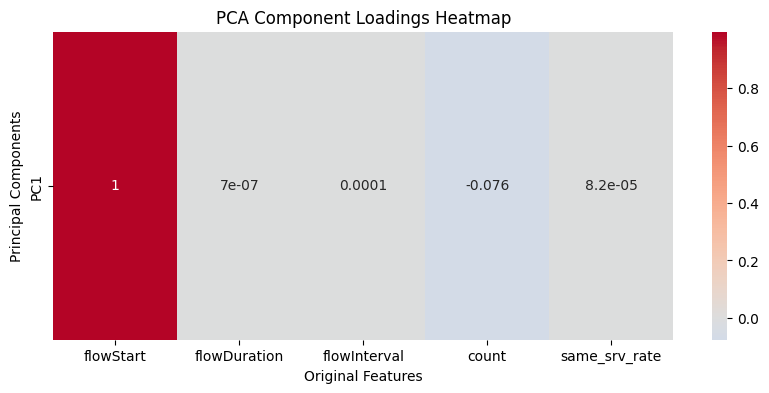

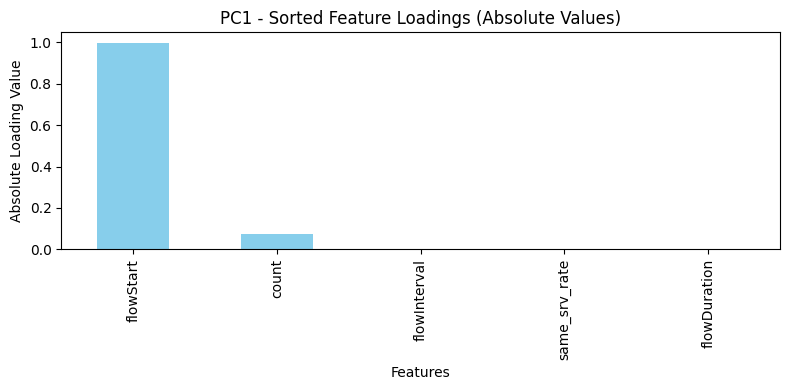

In [77]:
"""
PCA loadings are the coefficients of the linear combination of 
the original variables from which the principal components (PCs) are constructed.
describe how much each variable contributes to a particular principal component. 
Large loadings (positive or negative) indicate that a particular variable strongly 
relates to a particular principal component.
"""

component_labels = [f'PC{i+1}' for i in range(pca2.n_components_)]
loadings_df = pd.DataFrame(pca2.components_, columns=X_train.columns, index=component_labels)


# For each pc sort features by absolute loading values
for pc in loadings_df.index:
    sorted_loadings = loadings_df.loc[pc].abs().sort_values(ascending=False)
    print(f"Key features for {pc} :")
    print(sorted_loadings, "\n")

#heatmap for a visual interpretation of the loadings
plt.figure(figsize=(10, 4))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Component Loadings Heatmap")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()

#bar charts for each principal component's loadings
for pc in loadings_df.index:
    plt.figure(figsize=(8, 4))
    sorted_features = loadings_df.loc[pc].abs().sort_values(ascending=False)
    sorted_features.plot(kind='bar', color='skyblue')
    plt.title(f"{pc} - Sorted Feature Loadings (Absolute Values)")
    plt.xlabel("Features")
    plt.ylabel("Absolute Loading Value")
    plt.tight_layout()
    plt.show()

In [78]:
# Save features and labels separately
X_train.to_csv("X_train_preprocessed.csv", index=False)
X_test.to_csv("X_test_preprocessed.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
